# MF6. Relación entre niveles medidos y calculados

In [37]:
import flopy.mf6 as mf6
import flopy.utils.binaryfile as bf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Lectura del fichero con los niveles medidos en sondeos
(puntos de observación)
* Todos los sondeos están dentro del dominio del modelo.
* En este caso los tengo guardados en un fichero csv. 

In [8]:
fpath = r'E:\Cursos\H2OGEO\2023_Modelacion_HGeo\Ej_2\Niveles\_niveles_epsg25831_in_domain.csv'
df = pd.read_csv(fpath) 
df.head()

,sondeo,x,y,z,cnp,pnp,prof,campanya,anyo_lectura,observacio
0,SM1,432119.530805,4.591804e+06,30.309,21.809,8.5,25.0,< 2001,1999,NaN
1,SM3,432140.914559,4.591997e+06,30.465,22.965,7.5,23.0,< 2001,2005,NaN
2,SM5,432166.579268,4.592210e+06,31.177,24.177,7.0,18.5,< 2001,1999,NaN
3,SM6,432189.567023,4.592317e+06,32.000,24.500,7.5,20.0,< 2001,1999,NaN
4,SM20,432094.682088,4.591598e+06,29.255,21.255,8.0,26.0,< 2001,1990,NaN


## Rejilla del modelo

In [48]:
modelname = 'Moncada.nam'
model_ws = 'E:/Cursos/H2OGEO/2023_Modelacion_HGeo/Ej_2'
length_unit = 'm'

In [21]:
sim = mf6.MFSimulation.load(sim_name=modelname, exe_name='mf6', sim_ws=model_ws)
model_names = list(sim.model_names)
print('model names in sim', model_names)

gwf = sim.get_model(model_names[0])
print('gwf obj', type(gwf))

# model grid
sr = gwf.modelgrid
print('model grid', type(sr))

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package oc...
    loading package chd...
    loading package wel...
    loading package riv...
    loading package rch...
  loading solution package modflow...
model names in sim ['modflow']
gwf obj <class 'flopy.mf6.modflow.mfgwf.ModflowGwf'>
model grid <class 'flopy.discretization.structuredgrid.StructuredGrid'>


## Lectura de los h simulados del modelo (estacionario)

In [15]:
headfile = 'Moncada.bhd'

# Create a headfile object
headobj = bf.HeadFile(headfile)
print('head obj',type(headobj))

# Get all the times that heads were saved
times = headobj.get_times()

# Get the head data for the last saved time
head = headobj.get_data(totim=times[-1])
print('Simulated heads', type(head), head.shape)

head obj <class 'flopy.utils.binaryfile.HeadFile'>
Simulated heads <class 'numpy.ndarray'> (1, 248, 139)


## Asociar a cada sondeo la h simulada y cálculo de RMSE  

In [49]:
layer = 0  # upper layer
h_sim = []

for index, row in df.iterrows():
    sondeo = row['sondeo']
    x = row['x']
    y = row['y']
    cnp = row['cnp']
    row, col = sr.intersect(x, y)
    h1 = head[0, row, col]
    h_sim.append(h1)

df['h_sim'] = h_sim
df['er'] = df['cnp'] - df['h_sim']
mse = ((df['er'])**2).mean()
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse} {length_unit}')

result = df[['sondeo', 'cnp', 'h_sim', 'er']]
result.head()

Root Mean Squared Error (RMSE): 87.62884973060882 m


,sondeo,cnp,h_sim,er
0,SM1,21.809,-76.277131,98.086131
1,SM3,22.965,-72.688541,95.653541
2,SM5,24.177,-69.438155,93.615155
3,SM6,24.500,-68.408181,92.908181
4,SM20,21.255,-80.775667,102.030667


In [39]:
result.head(5)

,sondeo,cnp,h_sim,er
0,SM1,21.809,-76.277131,98.086131
1,SM3,22.965,-72.688541,95.653541
2,SM5,24.177,-69.438155,93.615155
3,SM6,24.500,-68.408181,92.908181
4,SM20,21.255,-80.775667,102.030667


## Plot h medida versus calculada

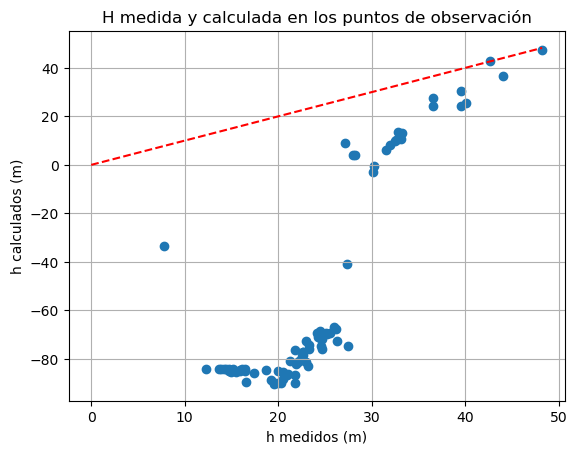

In [51]:
fig, ax = plt.subplots()

# Scatter plot
ax.scatter(df['cnp'], df['h_sim'], label='Data Points')

# Diagonal line (1 to 1 ratio)
ax.plot([0., df['cnp'].max()], [0., df['cnp'].max()], 
        color='red', linestyle='--', label='1:1 line')

# Set plot title and axis labels
ax.set_title('H medida y calculada en los puntos de observación')
ax.set_xlabel(f'h medidos ({length_unit})')
ax.set_ylabel(f'h calculados ({length_unit})')

# Display legend
#ax.legend()
ax.grid()
# Show the plot
plt.show()